In [21]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from numpy import reshape
import re
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [22]:
os.chdir("/Users/andrewcaffey/Documents/Projects/Data/PCPP/parts/monitor/parts/")
part_list = []
comments = []
for i in os.listdir(os.getcwd()):
    a = open(i, 'r')
    #print a.read()
    b = BeautifulSoup(a)

    #basic info
    if b.find('h4', attrs={'class':'kind'}) != None:
        kind = b.find('h4', attrs={'class':'kind'}).text
        part_name = b.find('h1', attrs={'class':'name'}).text
        link = b.find('input', attrs={'name':'url'})['value']
        info_dict = {'Kind':kind, 'Name':part_name, 'Link': link}

        #prices and vendor info
        if b.find_all('td', attrs={'class':'base'}) != None:
            price_list = b.find_all('td', attrs={'class':'base'})
            price_list = [float(x.text.strip('$')) for x in price_list]
            vendor_list = b.find_all('td', attrs={'class':'merchant'})
            vendor_list = [x.find('a', attrs={'target':'_blank'})['href'].split('/')[-2] for x in vendor_list]
            vendor_price_dict = {vendor:price for vendor, price in zip(vendor_list, price_list)}
            pricing_dict = {'Pricing':vendor_price_dict}
            price_dict = {'Prices':price_list,}

        #specs
        spec_labels = b.find('div', attrs={'class':'specs block'}).find_all('h4')
        spec_labels = [x.contents[0] for x in spec_labels]
        spec_values = str(b.find('div', attrs={'class':'specs block'}))

        vals = [x.strip().split('</h4>')[1].strip('\n').strip() for x in spec_values.split("<h4>")[1:]]
        vals[-1] = vals[-1].split('\n')[0]
        spec_values = vals

        spec_values = spec_values[0:len(spec_labels)+1]
        spec_dict = {spec_label:spec_value for spec_label, spec_value in zip(spec_labels,spec_values)}

        part_dict = dict(spec_dict.items() + info_dict.items() + price_dict.items() + pricing_dict.items())
        part_list.append(part_dict)

        #reviews
    reviews = b.find('div', attrs={'class':'part-reviews'})
    if reviews != None:
        reviews = reviews.find_all('div',attrs={'class':'part-review-block'})
        star_list = [len(reviews[x].find('ul',attrs={'class':'stars'}).find_all('li',attrs={'class':'full-star'})) for x in range(len(reviews))]

        comment_text_list = b.find_all('div', attrs={'class':'comment-message markdown'})
        comment_text_list = [comment_text_list[x].find_all('p') for x in range(len(comment_text_list))]

        comment_text_list_clean = []
        for i, x in enumerate(comment_text_list):
            comment = ""
            for y in x:
                try:
                    comment += y.contents[0] + " "
                except:
                    pass
            comment_text_list_clean.append(comment)

        

        review = zip(star_list, comment_text_list_clean)
        
        comments.append(review)
    
    a.close()
    b.decompose()

In [55]:
df = pd.DataFrame(part_list)

In [27]:
def score_vendors(prices):
    mean = np.mean([prices[x] for x in prices])
    std = np.std([prices[x] for x in prices])
    def z_score(std, mean, price):
        diff = float(price - mean)
        z_score = diff/std
        return z_score
    vendor_dict = {}
    for x in prices:
        vendor_z_score = z_score(std, mean, prices[x])
        vendor_dict[x] = vendor_z_score
    return vendor_dict

In [28]:
score_vendors(df.Pricing[0])

{'amazon': -0.32797597437736142,
 'bestbuy': -0.32797597437736142,
 'bhphotovideo': -0.81353357991043718,
 'jet': 2.1254374774198781,
 'ncixus': 0.11384168306856698,
 'superbiiz': -0.76979363182328986}

In [29]:
dict_list = []

for x in df.Pricing:
    z_score_dict = score_vendors(x)
    dict_list.append(z_score_dict)

In [30]:
vend_df = pd.DataFrame(dict_list)

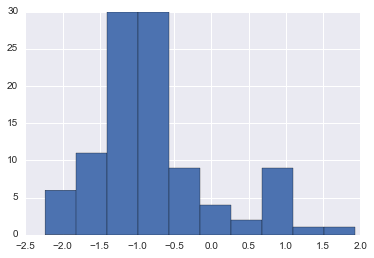

In [33]:
vend_df.amazon.dropna().hist()

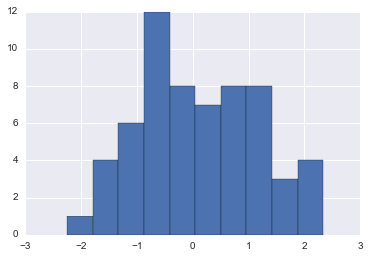

In [35]:
vend_df.bestbuy.dropna().hist()

In [38]:
vendor_avg = {}
for x in vend_df.columns:
    vendor_avg[x] = vend_df[x].dropna().sum()/vend_df[x].dropna().count()
    #plt.hist(vend_df[x].dropna())
    #vend_df[x].dropna().hist()

{'amazon': -0.7447879242690313,
 'bestbuy': 0.09043242123915231,
 'bhphotovideo': 0.00031863714700441345,
 'directron': 0.19597555639665679,
 'jet': 0.19501193545695888,
 'ncixus': 0.8811032786927802,
 'newegg': 0.00865147948643519,
 'neweggmkt': 0.73499887991885,
 'otherworldcomputing': 1.263523936361856,
 'outletpc': 0.5412991982604929,
 'pcmall': 0.16658595238512114,
 'superbiiz': -0.1917141398620513}

In [43]:
vendor_avg_chart = pd.DataFrame(vendor_avg, index=[0])

In [44]:
vendor_avg_chart

,amazon,bestbuy,bhphotovideo,directron,jet,ncixus,newegg,neweggmkt,otherworldcomputing,outletpc,pcmall,superbiiz
0,-0.744788,0.090432,0.000319,0.195976,0.195012,0.881103,0.008651,0.734999,1.263524,0.541299,0.166586,-0.191714


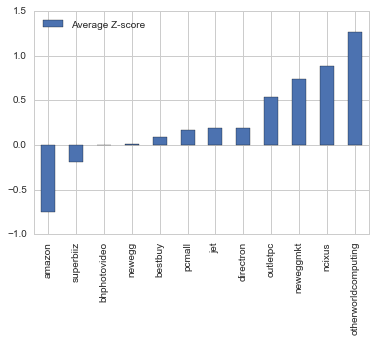

In [54]:
sns.set_style('whitegrid')
vendor_avg_chart.T.sort_values(by=0, ascending=True).plot(kind='bar')
plt.legend(['Average Z-score'], loc='upper left')

In [57]:
df.Brightness.value_counts()

250 cd/m²    347
300 cd/m²    132
350 cd/m²     50
200 cd/m²     32
400 cd/m²      8
340 cd/m²      5
270 cd/m²      5
440 cd/m²      4
370 cd/m²      2
180 cd/m²      2
320 cd/m²      2
280 cd/m²      2
220 cd/m²      1
210 cd/m²      1
360 cd/m²      1
Name: Brightness, dtype: int64

In [58]:
df['Screen Size'] = [x.strip('"') for x in df['Screen Size']]
df['screen_size'] = [float(x) for x in df['Screen Size']]

df['response'] = [float(x.strip('ms')) if type(x) == str else 0 for x in df['Response Time']]

df['avg'] = [sum(x)/len(x) if len(x) != 0 else 0 for x in df.Prices]
df['refresh'] = [float(x.strip('Hz')) if type(x) == str else 0 for x in df['Refresh Rate']]
df['Brightness'] = [float(x.split()[0]) if type(x)==str else 0 for x in df['Brightness']]

df['screen_res'] = [(float(x.split(':')[0]),float(x.split(':')[1])) for x in df['Aspect Ratio']]

#helper function for caluculating screen area
def screen_area(a_r, diag):
    a, b = a_r[0], a_r[1]
    scale = float(diag)/np.sqrt(a**2+b**2)
    area = scale*a*scale*b
    return area

def screen_dims(a_r, diag):
    a, b = a_r[0], a_r[1]
    scale = float(diag)/np.sqrt(a**2+b**2)
    return [scale*a,scale*b]

df['screen_area'] = [screen_area(x,y) for x, y in zip(df.screen_res,df.screen_size)]
df['screen_dims'] = [screen_dims(x,y) for x, y in zip(df.screen_res,df.screen_size)]

df['screen_x'] = [x[0] for x in df.screen_dims]
df['screen_y'] = [x[1] for x in df.screen_dims]

df.columns = [x.replace(' ', '_') for x in df.columns]

df['price_per_sq_in'] = [x/y for x, y in zip(df.avg, df.screen_area)]

In [59]:
df.to_csv('monitor_csv_final_final_FINAL_FINALLLL.csv', encoding='utf-8', index=False)

[120, 450, 0, 1000]

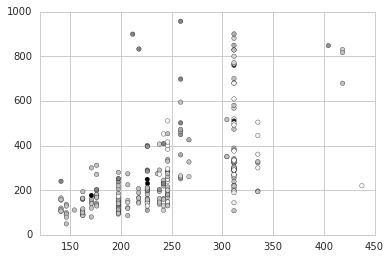

In [213]:
sns.set_style('whitegrid')
plt.scatter(df[df.avg>0].screen_area, df[df.avg>0].avg, c=df[df.avg>0].response)
plt.axis([120,450,0,1000])

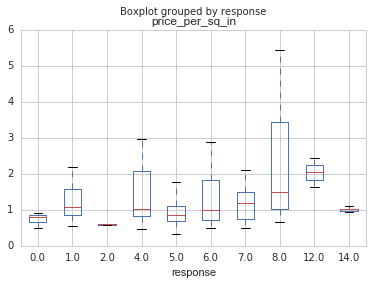

In [150]:
df[(df.avg>0)&(df.avg<1500)].boxplot(column='price_per_sq_in', by='response')

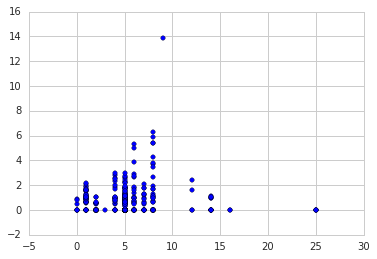

In [151]:
plt.scatter(df.response, df.price_per_sq_in)

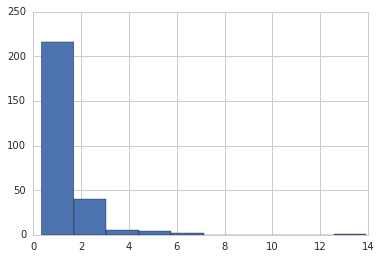

In [153]:
df[df.avg>0].price_per_sq_in.hist()

In [ ]:
df.to_csv('monitor_csv.csv', encoding='utf-8', index=False)

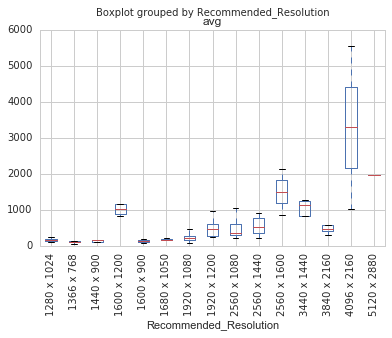

In [177]:
df[df.avg>0].boxplot(column='avg', by='Recommended_Resolution', rot=90)

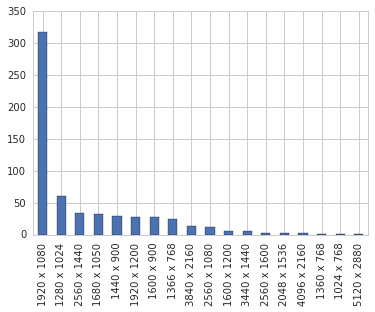

In [179]:
df.Recommended_Resolution.value_counts().plot(kind='bar')

In [198]:
df['price_std'] = [np.std(x) if len(x)>0 else 0 for x in df.Prices]

In [212]:
df['price_diff'] = [max(x) - min(x) if len(x)>0 else 0 for x in df.Prices]

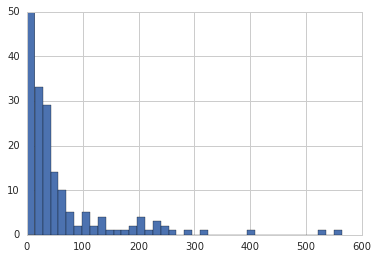

In [210]:
df[df.price_diff>0].price_diff.hist(bins=40)

In [211]:
df[df.price_diff>0].price_diff.mean()

61.538514285714285